# Correlation figure for twins activation maps

- grab activation maps
- Load pedigree
- stack in 3 dictionary :
    - MZ twins: Twin1, Twin2
    - DZ twins: Twin1, Twin2
    - Unrelated subject: S1, S2


In [1]:
import os
import glob
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec as gs
import nibabel as nib
import numpy as np
import pandas as pd
import multiprocessing 
import collections
import patsy as pat
from sklearn import linear_model as sln

In [2]:
%matplotlib inline
%load_ext oct2py.ipython

In [3]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
# Deal with minc being all weird
def roll_all(arr):
    tmp = arr
    for i in np.arange(len(arr.shape)):
        tmp = np.rollaxis(tmp, -1, i)
    return tmp

In [5]:
# Set path
path_root = '/media/yassine/data_disk/Drive/HCP2/'
path_h2r = os.path.join(path_root,'Solar_heritability/HCP_subtype/')
path_root_spm = '/media/yassine/data_disk/data/HCP/SPM/hcp_social_activation_maps_19-Aug-2017'

In [6]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [7]:
mat_file = os.path.join(path_root_spm,'stack_mental.mat')
%octave_push mat_file
%octave mat_load = load(mat_file);
%octave_pull mat_load

In [8]:
# Set task , trial and sbt
#task_names = ['emotion','social','relational','motor','gambling','wm','language']
task_names = 'social'
nb_sbt= 5
list_trial = os.listdir(os.path.join(path_root_spm,'group_maps'))
list_trial= [ll.split('.')[0] for ll in list_trial]

In [9]:
list_trial=list_trial[::-1]
list_trial

['mental', 'rnd', 'mental_vs_rnd']

In [10]:
dict_trial = {ind:trial for ind,trial in enumerate(list_trial)}

In [11]:
# get pheno file
pheno_file = os.path.join(path_root,"subtypes_scores/26-10-2016/pheno/hcp_pheno_{}_raw.csv".format(task_names))
pedig_df = pd.read_csv(pheno_file).filter(regex = r'(ID|Unnamed: 0|Zygosity|Twin_Stat|Gender)').rename(columns={'Unnamed: 0':'ID'})

In [12]:
pedig_df.head()

,ID,Gender,Twin_Stat,Zygosity,Mother_ID
0,HCP100206,1.0,NotTwin,NotTwin,56037.0
1,HCP100307,2.0,Twin,NotMZ,51488.0
2,HCP100408,1.0,Twin,MZ,51730.0
3,HCP100610,1.0,Twin,NotMZ,52813.0
4,HCP101006,2.0,Twin,MZ,51283.0


In [13]:
pedig_raw = pd.read_csv(pheno_file).rename(columns={'Unnamed: 0':'ID'})
mask_i = nib.load(os.path.join(path_root_spm,'func_mask_average_stereonl.nii.gz'))
mask = mask_i.get_data().astype(bool)

In [89]:
n_sub = pedig_raw.shape[0]
n_vox = np.sum(mask)
n_seed = len(dict_trial.keys())
resid_seed = np.zeros((n_sub, n_vox, n_seed))
ID_stak = list()
dict_resid = dict()

for sid in dict_trial.keys():
    if '_vs_'in dict_trial[sid]:
        trial = 'contrast_' + dict_trial[sid]
    else:
        trial = dict_trial[sid]
    # Build the regression model for the spm maps
    mod = sln.LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
    sub_seed = np.zeros((n_sub, n_vox))
    for rid, row in pedig_raw.iterrows():
        p = glob.glob(os.path.join(path_root_spm,'spm_maps',row['ID'],'all_runs','spm_{}.*'.format(trial)))
        if p:
            p=p[0]
            tmp_ = nib.load(p).get_data()
            if p.split('.')[-2] == 'mnc':
                tmp_ = roll_all(tmp_)
            d = tmp_[mask]
            sub_seed[rid, :] = d
            #ID_stak[rid,0] = row['ID']
            ID_stak.append(row['ID'])
        else:
            sub_seed[rid, :] = 'NaN'
            ID_stak.append('NaN')
    # remove NaN's from staks
    ID_= [x for x in ID_stak if str(x) != 'NaN']
    sub_=[row for row in sub_seed if not np.isnan(row).any()]
    # build model
    data = pedig_raw[pedig_raw['ID'].isin(ID_)]
    dmatrix = pat.dmatrix('FD_scrubbed_mean + BPSystolic + BPDiastolic + BMI', data=data)
    # get residual
    res = mod.fit(dmatrix, sub_)
    resid = sub_ - res.predict(dmatrix)
    dict_ = {'stack_{}'.format(trial):sub_ ,'resid_{}'.format(trial):resid , 'ID_{}'.format(trial):ID_}
    dict_resid.update(dict_)

In [90]:
dict_resid.keys()

dict_keys(['resid_mental', 'resid_contrast_mental_vs_rnd', 'stack_mental', 'stack_contrast_mental_vs_rnd', 'resid_rnd', 'ID_contrast_mental_vs_rnd', 'ID_rnd', 'ID_mental', 'stack_rnd'])

In [91]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

In [92]:
coll,a=_cmap_from_image_path('/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/Figures/subtypes/Paper_association_heritability/color_palette_raich4.png')
#invert color map
coll_r = matplotlib.colors.ListedColormap(coll[::-1])

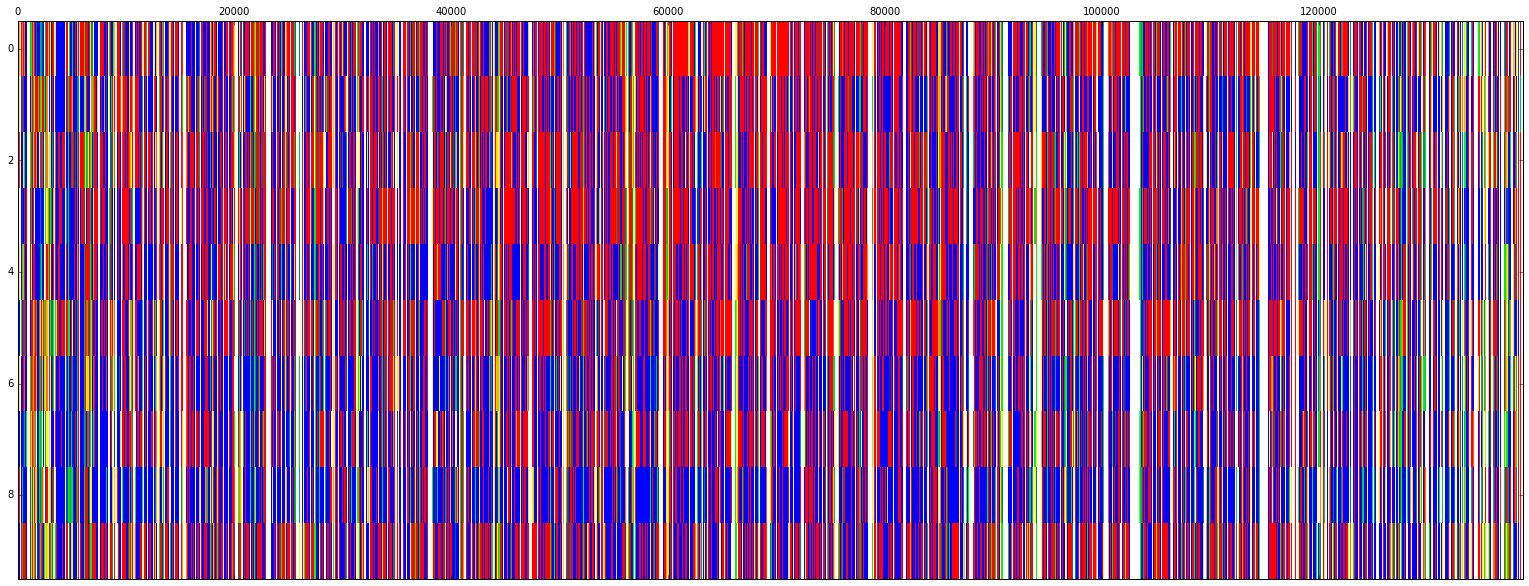

In [94]:
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(dict_resid['resid_mental'][-10:,:],aspect='auto',cmap =a,vmin=-0.00001, vmax=0.00001)

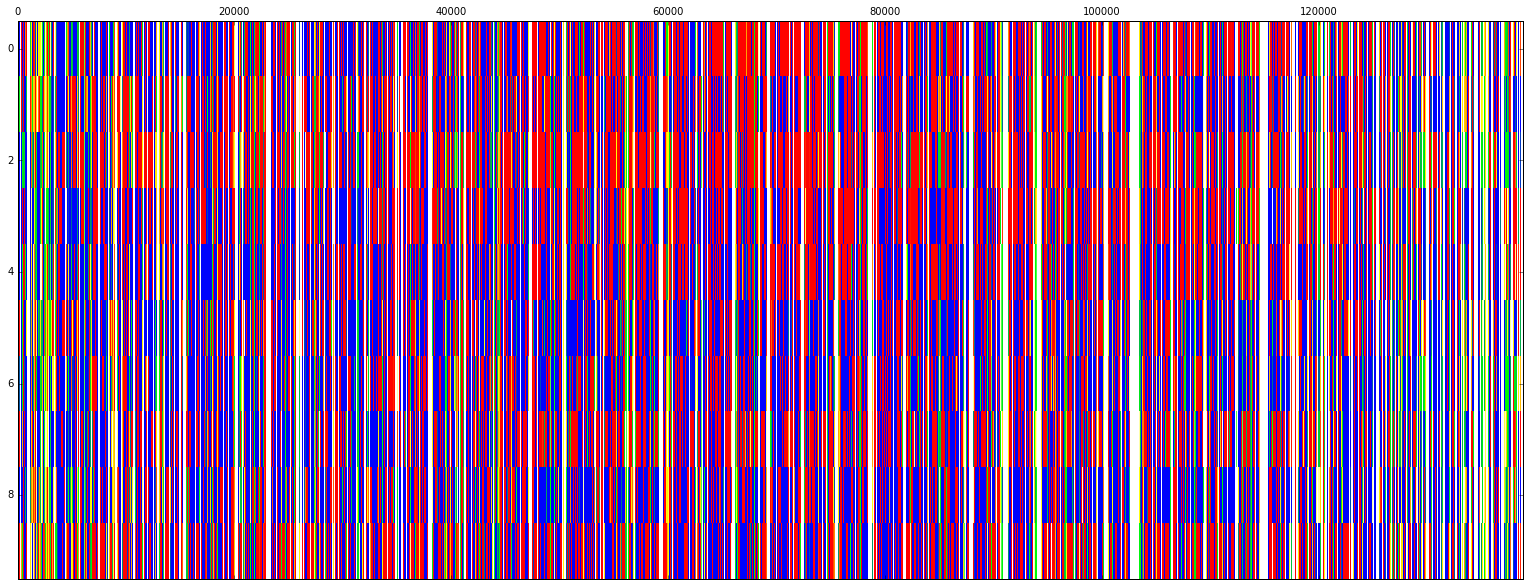

In [93]:
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(dict_resid['resid_rnd'][-10:,:],aspect='auto',cmap =a,vmin=-0.00001, vmax=0.00001)

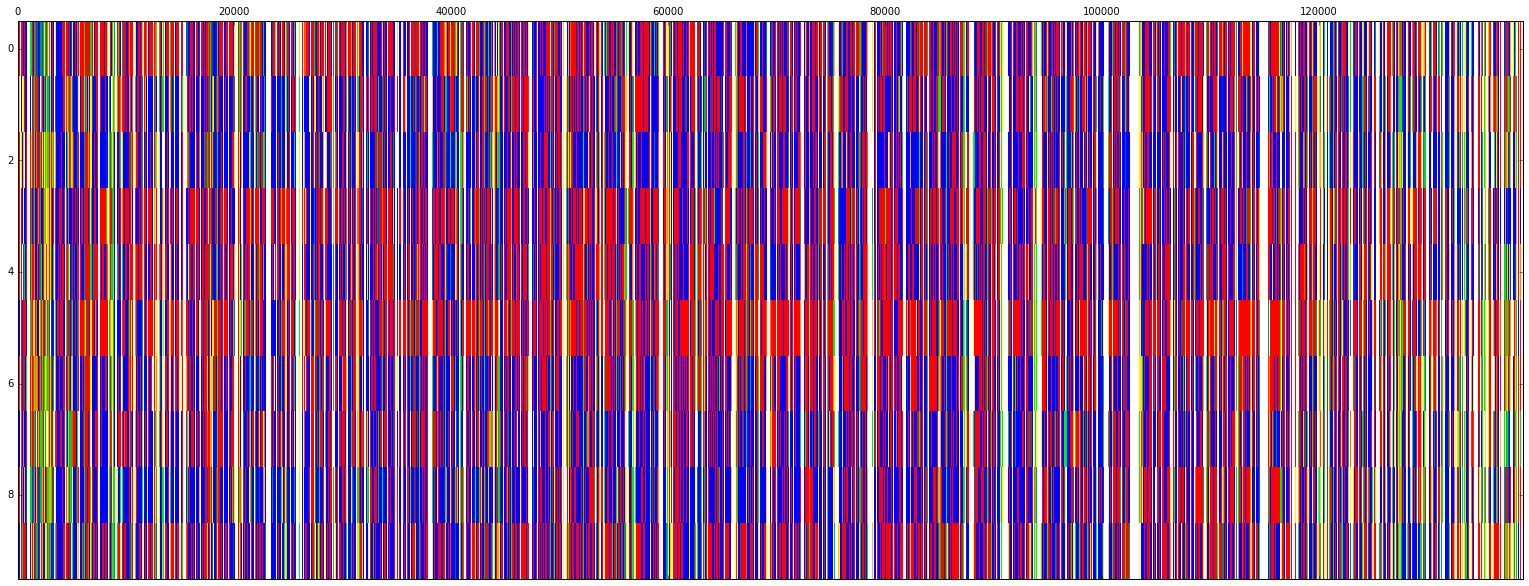

In [85]:
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(dict_resid['contrast_mental_vs_rnd'][-10:,:],aspect='auto',cmap =a,vmin=-0.00001, vmax=0.00001)

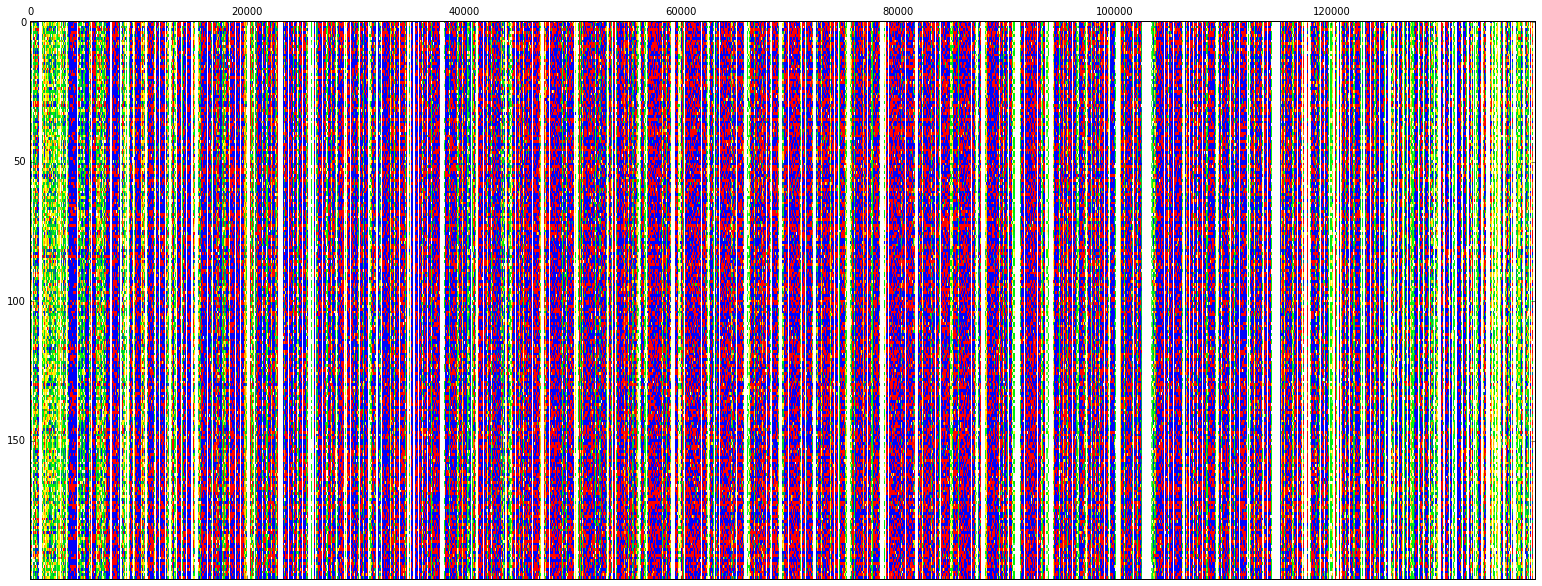

In [44]:
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(resid[:200],aspect='auto',cmap =a,vmin=-0.00004, vmax=0.00004)

In [31]:
sub_seed.max()

0.065909333527088165

In [105]:
p[0].split('.')[-2]

'mnc'

In [56]:
# MZ
MZ_df = pedig_df.loc[pedig_df['Zygosity'] == 'MZ']
mask_mz = [True if np.sum(MZ_df.Mother_ID == row.Mother_ID) == 2 else False for ind, row in MZ_df.iterrows()]
MZ_df_clean = MZ_df[mask_mz]
MZ_df_clean.count()

ID           152
Gender       152
Twin_Stat    152
Zygosity     152
Mother_ID    152
dtype: int64

In [57]:
# DZ
DZ_df = pedig_df.loc[pedig_df['Zygosity'] == 'NotMZ']
mask_dz = [True if np.sum(DZ_df.Mother_ID == row.Mother_ID) == 2 else False for ind, row in DZ_df.iterrows()]
DZ_df_clean = DZ_df[mask_dz]
DZ_df_clean.count()

ID           144
Gender       144
Twin_Stat    144
Zygosity     144
Mother_ID    144
dtype: int64

In [58]:
# Sib
Sib_df = pedig_df.loc[pedig_df['Zygosity'] == 'NotTwin']
mask_sib = [True if np.sum(Sib_df.Mother_ID == row.Mother_ID ) == 2 else False for ind, row in Sib_df.iterrows()]
Sib_df_clean = Sib_df[mask_sib]
Sib_df_clean.count()

ID           124
Gender       124
Twin_Stat    124
Zygosity     124
Mother_ID    124
dtype: int64

In [59]:
# # re-arrange Sib subject by pair of sibling
# list_Sib_pair=[Sib_df_clean[Sib_df_clean.Mother_ID == row.Mother_ID] 
#                for ind, row in Sib_df.iterrows() 
#                if not Sib_df_clean[Sib_df_clean.Mother_ID == row.Mother_ID].empty]
# list_Sib_pair=[list_Sib_pair[ii] for ii in range(int(len(list_Sib_pair)/2))]
# len(list_Sib_pair)

In [60]:
# Unr
UnR_df = pedig_df.loc[pedig_df['Zygosity'] == 'NotTwin']
mask_UnR = [True if np.sum(UnR_df.Mother_ID == row.Mother_ID) == 1 else False for ind, row in UnR_df.iterrows()]
UnR_df_clean = UnR_df[mask_UnR]
UnR_df_clean.count()

ID           210
Gender       210
Twin_Stat    210
Zygosity     210
Mother_ID    210
dtype: int64

In [107]:
#create a fake pair of mother id for unrelated person
samp_ = random.sample(range(1, 1000), int(len(UnR_df_clean)/2))
samp = samp_+samp_
UnR_df_clean.loc[:,'Mother_ID']=samp
UnR_df_clean.loc[:,'Zygosity']=['UnR']* int(len(UnR_df_clean))

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Fill dictionary

In [109]:
#initiate empty dictionary
dict_all = collections.namedtuple('dict_all', ['task','ID','trial','zygos','T1','T2','mask'])

In [110]:
dict_all_list =list()
mask  = os.path.join(path_root_spm,'func_mask_average_stereonl.nii.gz')
list_dict = [MZ_df_clean,DZ_df_clean,Sib_df_clean,UnR_df_clean]


for trial in list_trial:
    if '_vs_'in trial:
        trial = 'contrast_' + trial
    for dict_ in list_dict:
        zygos = dict_.Zygosity.iloc[0]
        for ID in dict_.Mother_ID.unique():
            pair1 = dict_[dict_.Mother_ID == ID].ID.get_values()[0]
            pair2 = dict_[dict_.Mother_ID == ID].ID.get_values()[1]
            
            spm_path1 = glob.glob(os.path.join(path_root_spm,
                                               'spm_maps',
                                               pair1,
                                               'all_runs',
                                               'spm_{}.*'.format(trial)))
            spm_path2 = glob.glob(os.path.join(path_root_spm,
                                               'spm_maps',
                                               pair2,
                                               'all_runs',
                                               'spm_{}.*'.format(trial)))
            if spm_path1 and spm_path2 :

                dict_all_list.append(dict_all(ID=ID,
                                              task = task_names,
                                              zygos = zygos,
                                              trial = trial,
                                              T1 = spm_path1,
                                              T2 = spm_path2,
                                              mask = mask))
                continue        
            elif not spm_path1:
                print("subject {} doesnt have a file for trial {}".format(pair1,trial))
            elif not spm_path2:
                print("subject {} doesnt have a file for trial {}".format(pair2,trial))

subject HCP115825 doesnt have a file for trial mental
subject HCP114924 doesnt have a file for trial mental
subject HCP188549 doesnt have a file for trial mental
subject HCP205119 doesnt have a file for trial mental
subject HCP927359 doesnt have a file for trial mental
subject HCP207123 doesnt have a file for trial mental
subject HCP173637 doesnt have a file for trial mental
subject HCP208428 doesnt have a file for trial mental
subject HCP304020 doesnt have a file for trial mental
subject HCP110613 doesnt have a file for trial mental
subject HCP113619 doesnt have a file for trial mental
subject HCP270332 doesnt have a file for trial mental
subject HCP485757 doesnt have a file for trial mental
subject HCP156233 doesnt have a file for trial mental
subject HCP165840 doesnt have a file for trial mental
subject HCP115825 doesnt have a file for trial rnd
subject HCP114924 doesnt have a file for trial rnd
subject HCP188549 doesnt have a file for trial rnd
subject HCP205119 doesnt have a file 

In [112]:
def run_corr(x):
    results =dict()
    m_img = nib.load(x.mask)
    mask_data = m_img.get_data()
    mask = mask_data != 0
        
    for trial in list_trial:
        if '_vs_'in x.trial:
            trial = 'contrast_' + trial

        if x.trial == trial:
            tmp_1 = nib.load(x.T1[0]).get_data()
            if x.T1[0].split('.')[-2] == 'mnc':
                tmp_1 = roll_all(tmp_1)
            tmp_2 = nib.load(x.T2[0]).get_data()
            if x.T2[0].split('.')[-2] == 'mnc':
                tmp_2 = roll_all(tmp_2)
            vol1 = tmp_1[mask]
            vol2 = tmp_2[mask]
            corr  = np.corrcoef(vol1,vol2)
            results = {'task':x.task,
                       'zygos':x.zygos,
                       'trial_name' : x.trial,
                       'corr' : corr,
                       'ID' : x.ID
                        }
    return results

In [113]:
# run parralel process
pool = multiprocessing.Pool()
res_= pool.map(run_corr,dict_all_list)

In [114]:
# grab each trial  result
result_final = []
result_ = list()

for trial in list_trial:
    if '_vs_'in trial:
        trial = 'contrast_' + trial
    for zy in ['MZ','NotMZ','NotTwin','UnR']:
        corr_list = [x['corr'][0,1] for x in res_ if x['trial_name'] == trial and x['zygos'] == zy ]
        result_dict =  {'task': task_names,
                        'trial_name' : trial,
                        'zygos':zy,
                        'coor_list' : corr_list,
                        'mean_corr' : np.mean(corr_list),
                        'std_corr'  : np.std(corr_list)}
        result_.append(result_dict)
        # grab trial corr and std
tmp_=[[res['task'],res['trial_name'],res['zygos'], res['mean_corr'], res['std_corr']] for res in result_]
result_final = result_final + tmp_

In [115]:
corr_df = pd.DataFrame(result_final,columns=['task','trial','zygosity','corr','std'])
corr_df

,task,trial,zygosity,corr,std
0,social,mental,MZ,0.577992,0.064020
1,social,mental,NotMZ,0.522683,0.096765
2,social,mental,NotTwin,0.499752,0.094465
3,social,mental,UnR,0.471099,0.084056
4,social,rnd,MZ,0.554606,0.074769
5,social,rnd,NotMZ,0.521670,0.104921
6,social,rnd,NotTwin,0.464912,0.094600
7,social,rnd,UnR,0.440564,0.092212
8,social,contrast_mental_vs_rnd,MZ,0.194586,0.121029
9,social,contrast_mental_vs_rnd,NotMZ,0.154184,0.098571


In [116]:
#save to csv
corr_df.to_csv(os.path.join(path_root_spm,'corr_{}.csv'.format(task_names)))

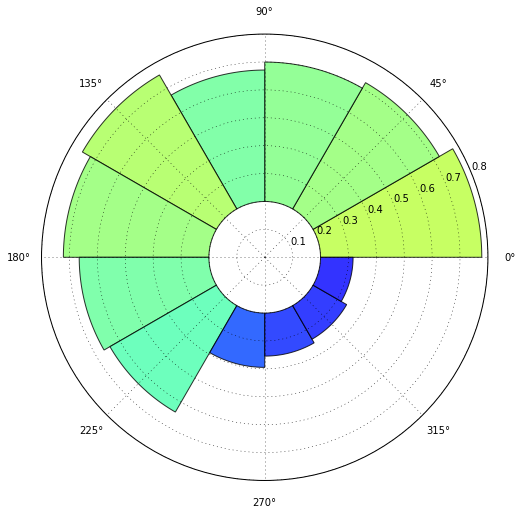

In [118]:
# main fig h2r
N = corr_df['corr'].shape[0]
bottom = 0.2
max_height = 1

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
#radii = max_height*np.random.rand(N)
radii = corr_df['corr']
width = (2*np.pi) / N
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r))
    bar.set_alpha(0.8)
    bar.yerr= corr_df['std']
f.savefig(os.path.join(path_root_spm,'corr_{}.svg'.format(task_names)))